In [2]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import math 
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.rc("figure", figsize=(18,5))

In [3]:
def Dickey_Fuller_test(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    Dickey_Fuller_test(timeseries)
    
def plot_residuals(df):
    # plot residual erros
    residuals = pd.DataFrame(df)
    residuals.plot()
    residuals.plot(kind='kde')
    print(residuals.describe())
    (residuals*residuals).plot()
    plot_correlation(residuals*residuals)
    
def plot_correlation(data):
    plot_acf(data,lags=20)
    plt.show()
    plot_pacf(data,lags=20)
    plt.show()

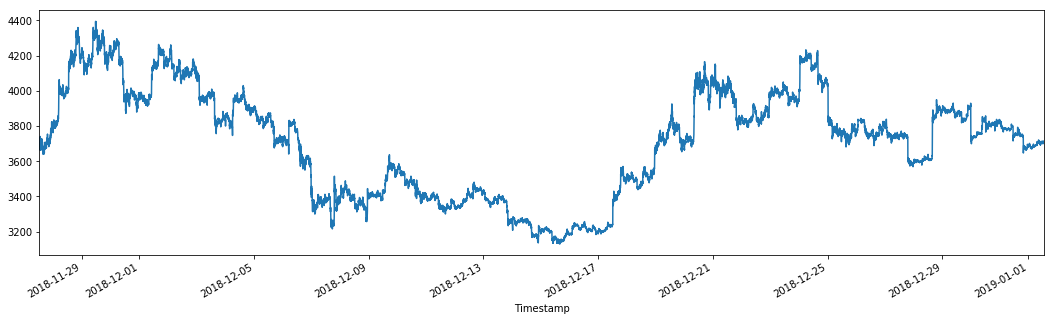

In [20]:
# Učitavanje podataka. Kao dataset sam uzeo zadnjih 7200 minuta ili zadnjih 8 dana
data = pd.read_pickle("/home/filip/Desktop/Ruđer/FinalData/general.pkl")
data = data.set_index("Timestamp")
data = data["Weighted_Price_x"].tail(50000)
data.plot()

In [21]:
# Vremenska serija nije stacionarna p>0.05
Dickey_Fuller_test(data.tail(1000))

Results of Dickey-Fuller Test:
Test Statistic                  -3.717664
p-value                          0.003871
#Lags Used                      14.000000
Number of Observations Used    985.000000
Critical Value (1%)             -3.437006
Critical Value (5%)             -2.864479
Critical Value (10%)            -2.568335
dtype: float64


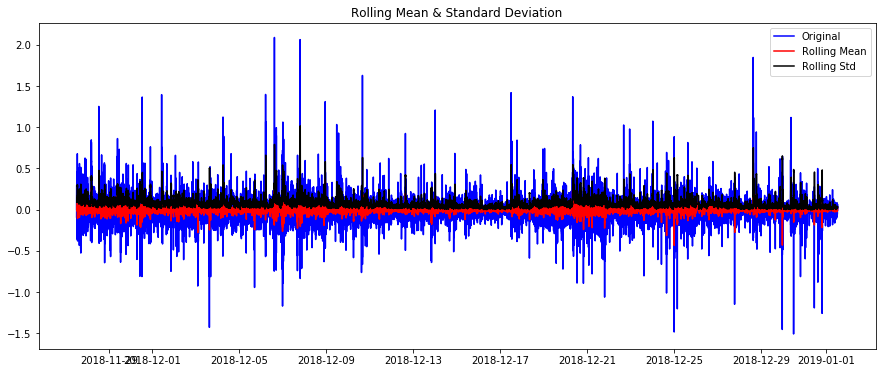

Results of Dickey-Fuller Test:
Test Statistic                   -44.495909
p-value                            0.000000
#Lags Used                        24.000000
Number of Observations Used    49975.000000
Critical Value (1%)               -3.430481
Critical Value (5%)               -2.861598
Critical Value (10%)              -2.566801
dtype: float64


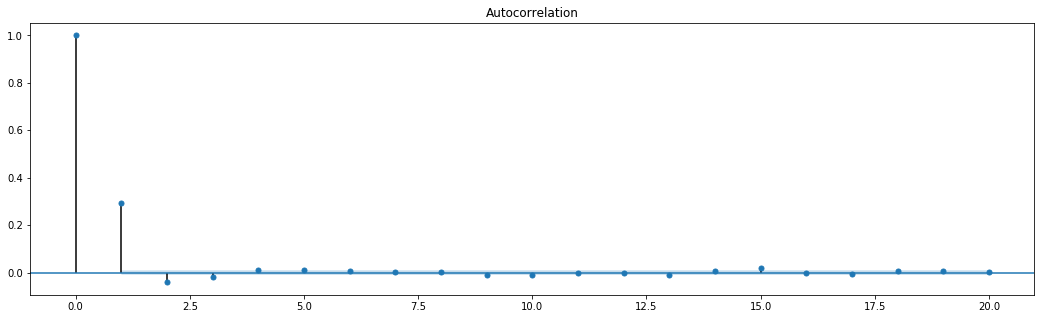

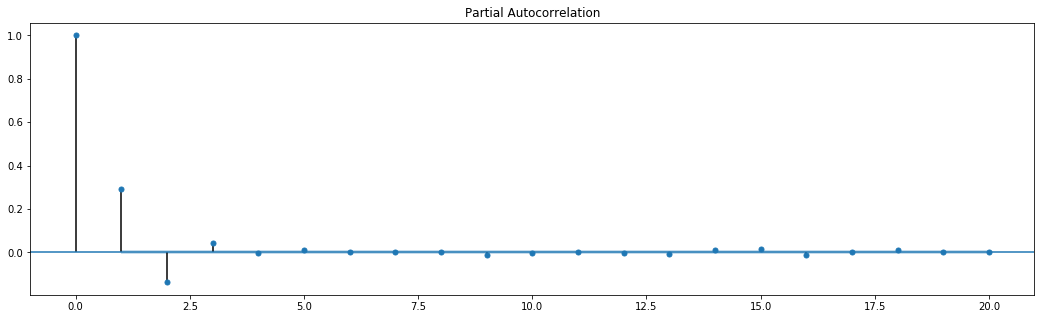

In [22]:
# Transformiramo vremensku seriju u stacionarni oblik. Nakon transformacije u postotnu promjenu 
# vremenska serija postaje stacionarana p<0.05.
data = data.pct_change()*100
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)
test_stationarity(data)
plot_correlation(data)

In [23]:
# Razdvajamo podatke u train i test set
train = data[:-100]
print(train.replace([np.inf, -np.inf], np.nan).isnull().sum())
train = train.fillna(0)
test = data[-100:]
print(test.replace([np.inf, -np.inf], np.nan).isnull().sum())
test = test.fillna(0)

0
0


In [24]:
# Funkcija koja vraća najbolji model. Uzima se zbroj bica i aica
def get_best_model(TS):
    best = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(3) # [0,1,2,3,4]
    d = 0
    qq_rng = range(3)
    for i in pq_rng:
        for j in qq_rng:
            try:
                tmp_mdl = ARIMA(TS, order=(i,d,j)).fit(
                    method='mle', trend='nc', freq="T"
                )
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                if tmp_aic+tmp_bic < best:
                    best_aic = tmp_aic
                    best_bic = tmp_bic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
                    print("best:",i,d,j)
            except: continue
        print(i,d,j)
    print('aic: {:6.2f} | order: {}'.format(best_aic,best_bic, best_order))                    
    return best_aic, best_order, best_mdl

In [25]:
res_tup = get_best_model(train)
model = res_tup[2]
order = res_tup[1]
p_ = order[0]
o_ = order[1]
q_ = order[2]
print(res_tup[2].summary())

best: 0 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best: 0 0 2
0 0 2
best: 1 0 0


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best: 1 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best: 1 0 2
1 0 2
best: 2 0 0


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best: 2 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best: 2 0 2
2 0 2
aic: -87921.63 | order: -87877.54265446133
                              ARMA Model Results                              
Dep. Variable:       Weighted_Price_x   No. Observations:                49900
Model:                     ARMA(2, 2)   Log Likelihood               43965.816
Method:                           mle   S.D. of innovations              0.100
Date:                Fri, 06 Sep 2019   AIC                         -87921.632
Time:                        01:55:57   BIC                         -87877.543
Sample:                             0   HQIC                        -87907.820
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
ar.L1.Weighted_Price_x    -0.0728      0.142     -0.511      0.610      -0.352       0.206
ar.L2.Weighted_Price_x    -0.0733 

                  0
count  4.990000e+04
mean   6.181741e-05
std    1.002581e-01
min   -1.459080e+00
25%   -3.358951e-02
50%   -5.252575e-07
75%    3.278337e-02
max    2.133452e+00


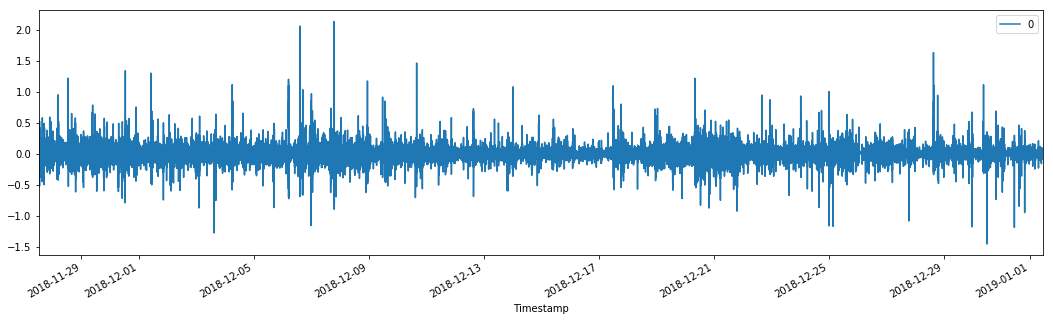

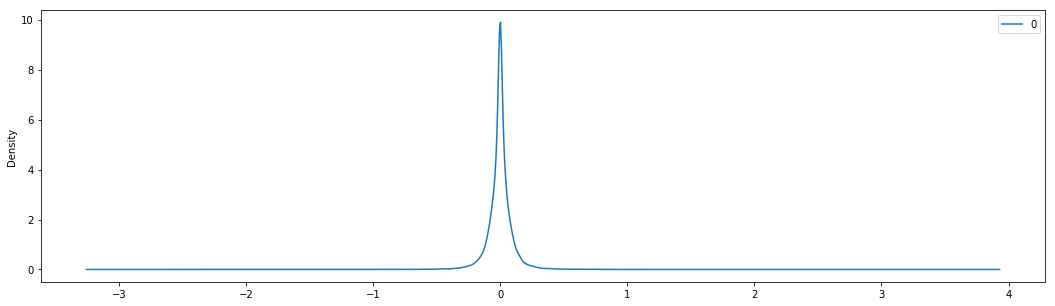

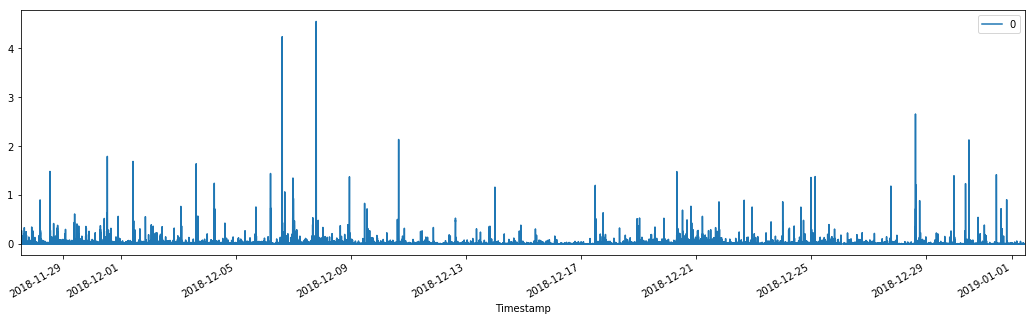

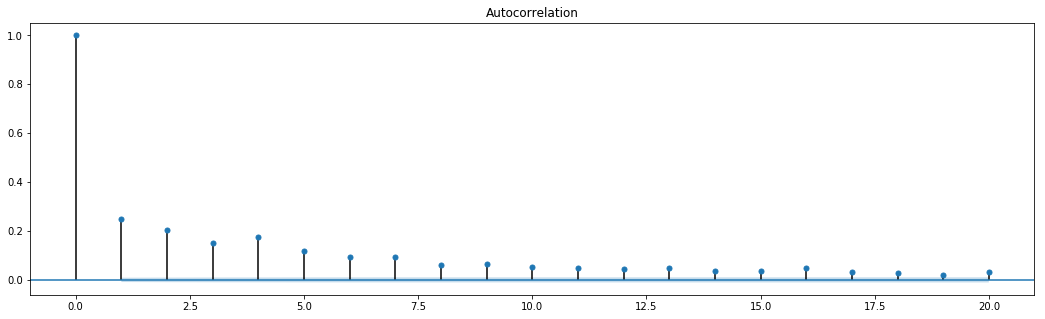

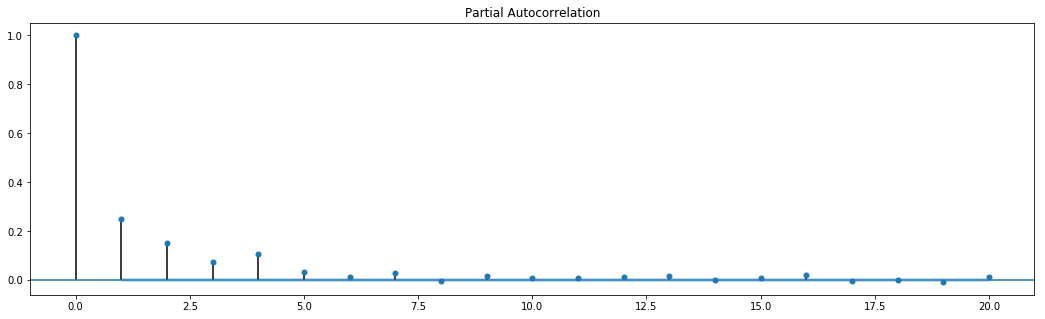

In [26]:
# Plotanje residualsa radi provjere dali jos uvijek postoji korelacija. Traži se da ostatci izgledaju poput
# bijelog šuma. Ovdje nije dobiven taj rezultat što znači da model ima neki nedostatak. Arima je najvjerojatnije
# pre jednostavan za ovaj dataset.
plot_residuals(model.resid)

In [27]:
# Pokušaj treniranja GARCH modela na residualnoj vremenskoj seriji
am = arch_model(model.resid, p=3, o=0, q=2, dist='StudentsT')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:     10,   Neg. LLF: -63265.53763568565
Iteration:      2,   Func. Count:     29,   Neg. LLF: -63265.59942147485
Iteration:      3,   Func. Count:     48,   Neg. LLF: -63265.64010296715
Iteration:      4,   Func. Count:     65,   Neg. LLF: -63265.640636831165
Iteration:      5,   Func. Count:     83,   Neg. LLF: -63265.64256059964
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -63265.642568728596
            Iterations: 9
            Function evaluations: 83
            Gradient evaluations: 5


/home/filip/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                63265.6
Distribution:      Standardized Student's t   AIC:                          -126515.
Method:                  Maximum Likelihood   BIC:                          -126445.
                                              No. Observations:                49900
Date:                      Fri, Sep 06 2019   Df Residuals:                    49892
Time:                              01:56:11   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

              resid
count  49900.000000
mean      -0.000102
std        0.100258
min       -1.459244
25%       -0.033754
50%       -0.000165
75%        0.032619
max        2.133288


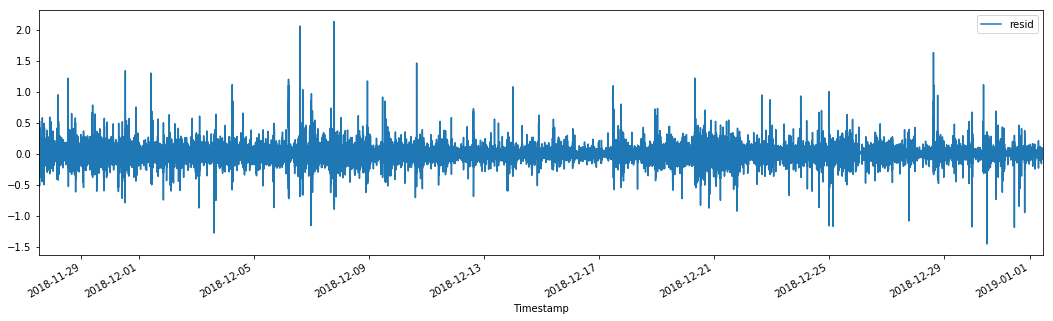

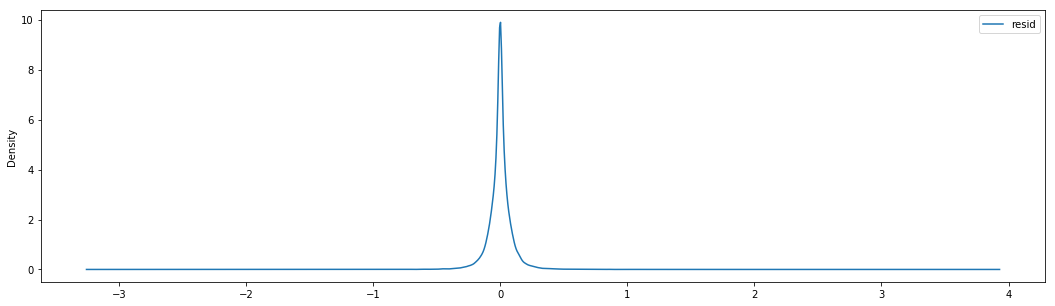

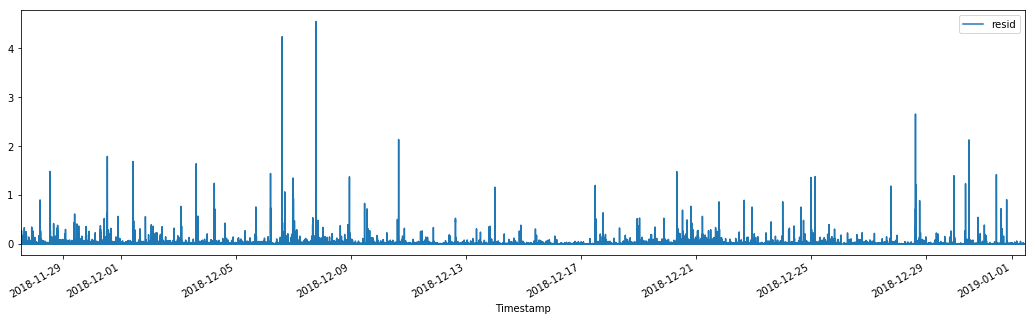

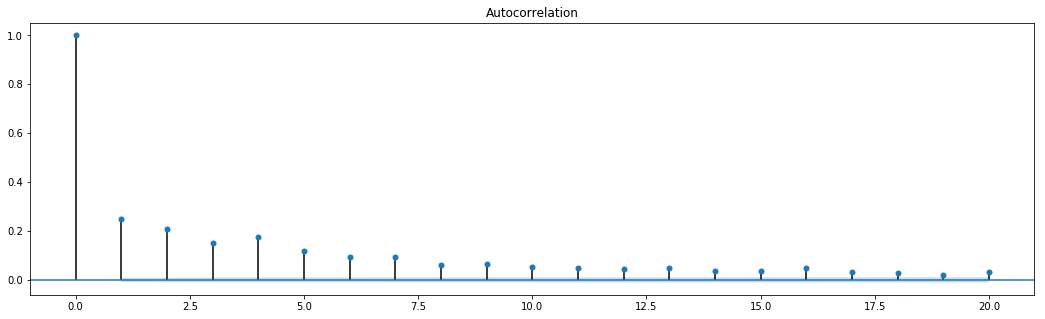

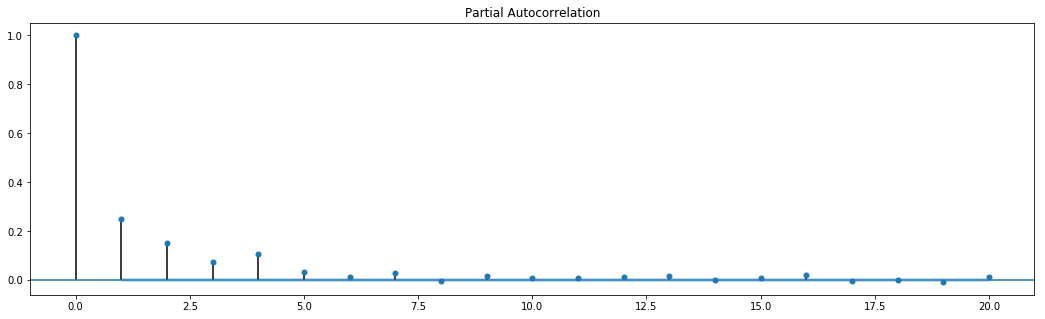

In [28]:
# Model nije ništa naučio....
plot_residuals(res.resid)

In [29]:
# Treniranje i predikcija rezultata za idući dan
history = [x for x in train]
history = history
print(len(test))
predictions = []
for t in range(len(test)):
    obs = test[t]
    #Arima model fitting
    model = ARIMA(history, order=(p_,o_,q_))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    #Results
    residuals = model_fit.resid
    yhat = output[0]
    
    #Appending results
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

100
predicted=0.001112, expected=0.010102
predicted=0.002913, expected=0.008717
predicted=0.001627, expected=-0.000464
predicted=-0.001033, expected=0.017933
predicted=0.006488, expected=0.013705
predicted=0.001857, expected=0.000045
predicted=-0.001238, expected=-0.000081
predicted=0.000463, expected=0.005472
predicted=0.001825, expected=-0.001438
predicted=-0.001251, expected=0.005436
predicted=0.002357, expected=-0.000494
predicted=-0.001050, expected=0.000270
predicted=0.000482, expected=-0.000081
predicted=-0.000076, expected=0.000216
predicted=0.000169, expected=0.000090
predicted=0.000054, expected=0.000045
predicted=0.000073, expected=-0.000216
predicted=-0.000015, expected=0.000216
predicted=0.000169, expected=0.028977
predicted=0.009815, expected=0.072561
predicted=0.020156, expected=0.038586
predicted=0.003222, expected=-0.008669
predicted=-0.005907, expected=-0.113321
predicted=-0.035851, expected=-0.005986
predicted=0.014797, expected=0.005070
predicted=-0.002078, expected

Test MSE: 0.0006794525


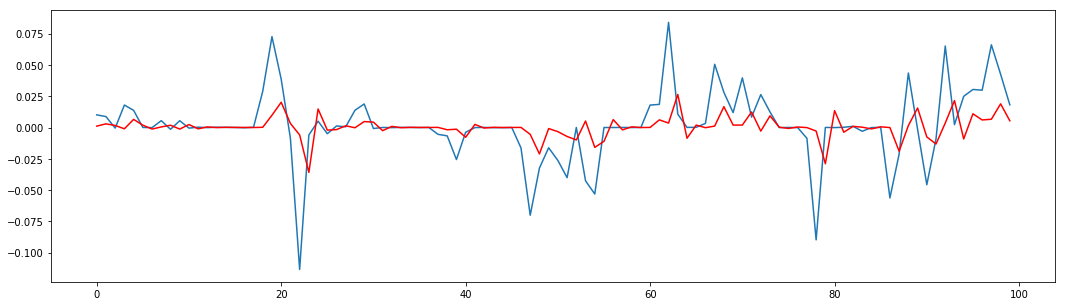

In [30]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.10f' % error)
plt.plot(test.values)
plt.plot(predictions, color='red')